

Section 1


In [ ]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

# Data Visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# System
import os

# Deep Learning
import tensorflow as tf
from typing import Dict, List, Tuple, Sequence
import openmeteo_requests
import requests_cache
from retry_requests import retry

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"start_date": "2020-10-15",
	"end_date": "2025-10-15",
	"hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature", "precipitation", "wind_speed_10m", "cloud_cover", "pressure_msl"],
	"timezone": "Europe/Berlin",
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone: {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")


Coordinates: 52.5483283996582°N 13.407821655273438°E
Elevation: 38.0 m asl
Timezone: b'Europe/Berlin'b'GMT+1'
Timezone difference to GMT+0: 3600s


In [ ]:
# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(3).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(5).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(6).ValuesAsNumpy()
hourly_pressure_msl = hourly.Variables(7).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["dew_point_2m"] = hourly_dew_point_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["precipitation"] = hourly_precipitation
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["pressure_msl"] = hourly_pressure_msl

df = pd.DataFrame(data = hourly_data)

In [ ]:
df_dt = df[['date']].copy()
df_dt['day_of_week'] = df_dt['date'].map(lambda x: x.dayofweek)
df_dt['day_of_year'] = df_dt['date'].map(lambda x: x.dayofyear)
df_dt['hour'] = df_dt['date'].map(lambda x: x.hour)
# Get the number of seconds for each time period
day = 24
week = 7
year = 365

# Transform using sin and cos
# Time of day
df_dt['hour_sin'] = np.sin(df_dt['hour'] * (2 * np.pi / day))
df_dt['hour_cos'] = np.cos(df_dt['hour'] * (2 * np.pi / day))

# Time of week
df_dt['week_sin'] = np.sin(df_dt['day_of_week'] * (2 * np.pi / week))
df_dt['week_cos'] = np.cos(df_dt['day_of_week'] * (2 * np.pi / week))

# Time of year
df_dt['year_sin'] = np.sin(df_dt['day_of_year'] * (2 * np.pi / year))
df_dt['year_cos'] = np.cos(df_dt['day_of_year'] * (2 * np.pi / year))

In [ ]:
df_dt.head(2)

,date,day_of_week,day_of_year,hour,hour_sin,hour_cos,week_sin,week_cos,year_sin,year_cos
0,2020-10-14 23:00:00+00:00,2,288,23,-0.258819,0.965926,0.974928,-0.222521,-0.970064,0.242850
1,2020-10-15 00:00:00+00:00,3,289,0,0.000000,1.000000,0.433884,-0.900969,-0.965740,0.259512


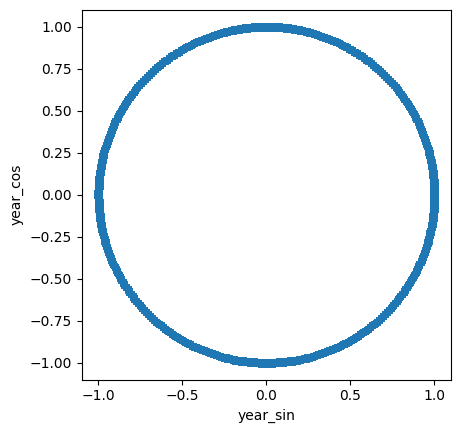

In [ ]:
df_dt.plot.scatter('year_sin', 'year_cos').set_aspect('equal')

In [ ]:
df = df.merge(df_dt[['date', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos']], on='date', how='left')

In [ ]:
data = df.drop('date', axis=1)
data = data[['hour_sin', 'hour_cos', 'week_sin',
       'week_cos', 'year_sin', 'year_cos', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'wind_speed_10m', 'cloud_cover', 'pressure_msl']]


In [ ]:
# Let's define the global variables of our dataset
TARGET = 'temperature_2m'
N_TARGETS = 1
N_FEATURES = 14


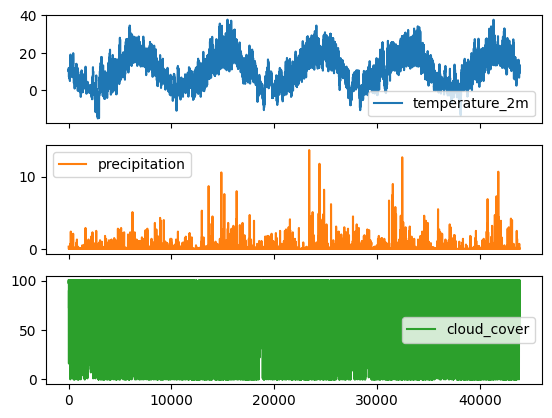

In [ ]:
plot_cols = [TARGET, 'precipitation', 'cloud_cover']
plot_features = data[plot_cols]
plot_features.index = data.index
plot_features.plot(subplots = True);

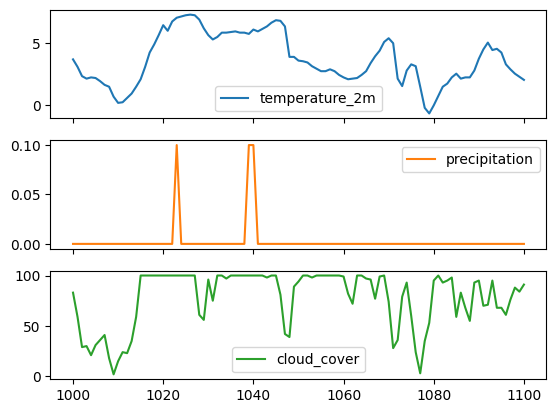

In [ ]:
zoomed_slice = slice(1000,1100)

plot_features = data.loc[zoomed_slice, plot_cols]
plot_features.plot(subplots = True);

In [ ]:
INPUT_LENGTH = 24 * 14 # records every 3 hours x 8 = 24 hours
                      # two weeks
                      # TARGET Y
TARGET = 'temperature_2m'
N_TARGETS = 1
N_FEATURES = 14
print(f'N_TARGETS = {N_TARGETS}')

# Let's only predict 1 value ahead of us
OUTPUT_LENGTH = 12
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')


N_TARGETS = 1
OUTPUT_LENGTH = 12


In [ ]:
data.columns


Index(['hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
       'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'wind_speed_10m',
       'cloud_cover', 'pressure_msl'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split

def create_train_test_splits(data, lookback=336, forecast_horizon=12, test_size=0.2):
    """
    data: complete dataset (43848, 14)
    lookback: hours of history to use (336)
    forecast_horizon: hours to predict (12)
    test_size: proportion of data for testing
    """
    n_samples = len(data) - lookback - forecast_horizon + 1

    # Create sequences
    X, y = [], []
    for i in range(n_samples):
        X.append(data[i:i+lookback])  # Lookback window: shape (336, 14)

        # Target: next 12 hours of the first column (assuming target is column 0)
        # Make sure we extract just the target values, not a slice
        target_start = i + lookback
        target_end = target_start + forecast_horizon
        target_values = data[target_start:target_end, 6]  # Column 6 is your target

        y.append(target_values)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [ ]:
X_train_all, X_test_all, y_train_all, y_test_all = create_train_test_splits(data.values)

In [ ]:
y_test_all.shape

(8701, 12)

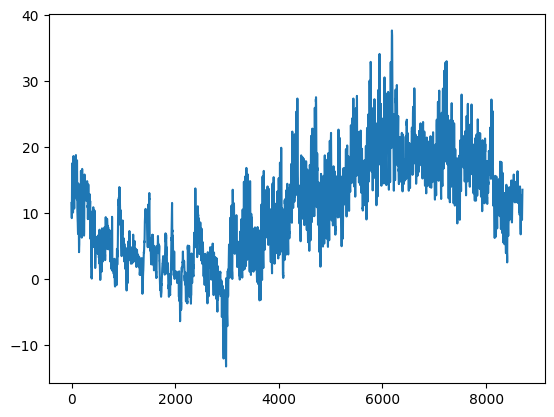

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_test_all[:,1])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.3, random_state=42, shuffle=False
)

In [27]:
from keras import Model, Input
from keras.layers import Normalization, LSTM, Dense
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping


es = EarlyStopping(monitor = "val_mae",
                           mode = "min",
                           patience = 2,
                           restore_best_weights = True)

def init_model_new(X_train):
    # Define input
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # Create normalization layer and adapt it
    normalizer = Normalization()
    normalizer.adapt(X_train)

    # Build model
    x = normalizer(inputs)
    x = LSTM(units=20, activation='tanh')(x)
    x = Dense(50, activation='relu', kernel_regularizer=L1L2(l1=0.05, l2=0.05))(x)
    outputs = Dense(12, activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model

# Create the model
model = init_model_new(X_train_all)

# Split for validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.3, random_state=42, shuffle=False
)

# Now train
history_all = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    verbose=1,
    callbacks=[es]
)

Epoch 1/100
762/762 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - loss: 66.5362 - mae: 5.2458 - val_loss: 10.5977 - val_mae: 1.9161
Epoch 2/100
762/762 ━━━━━━━━━━━━━━━━━━━━ 77s 65ms/step - loss: 9.3779 - mae: 1.6977 - val_loss: 7.5370 - val_mae: 1.6011
Epoch 3/100
762/762 ━━━━━━━━━━━━━━━━━━━━ 50s 66ms/step - loss: 6.7488 - mae: 1.4391 - val_loss: 5.8224 - val_mae: 1.4282
Epoch 4/100
762/762 ━━━━━━━━━━━━━━━━━━━━ 49s 65ms/step - loss: 5.5948 - mae: 1.3583 - val_loss: 5.3470 - val_mae: 1.4011
Epoch 5/100
762/762 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - loss: 4.9695 - mae: 1.3087 - val_loss: 5.0197 - val_mae: 1.3821
Epoch 6/100
762/762 ━━━━━━━━━━━━━━━━━━━━ 89s 74ms/step - loss: 4.5065 - mae: 1.2653 - val_loss: 5.2312 - val_mae: 1.4616
Epoch 7/100
762/762 ━━━━━━━━━━━━━━━━━━━━ 50s 65ms/step - loss: 4.2720 - mae: 1.2467 - val_loss: 5.7280 - val_mae: 1.5860


In [29]:
def plot_history(history):

    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE ---
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- METRICS:MAE ---

    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    return ax

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

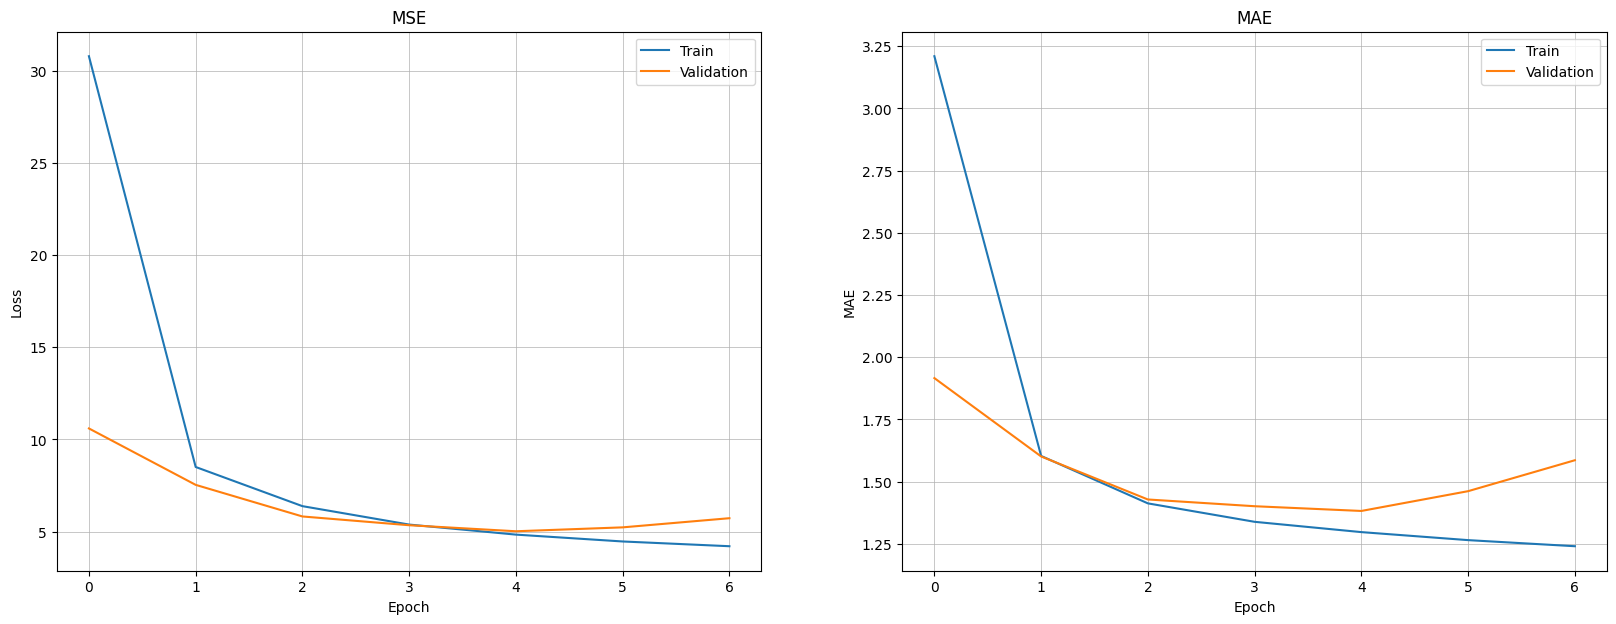

In [30]:
plot_history(history_all)

In [31]:
y_pred = model.predict(X_test_all)

272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step


In [33]:
print(y_pred.shape, y_test_all.shape)

(8701, 12) (8701, 12)


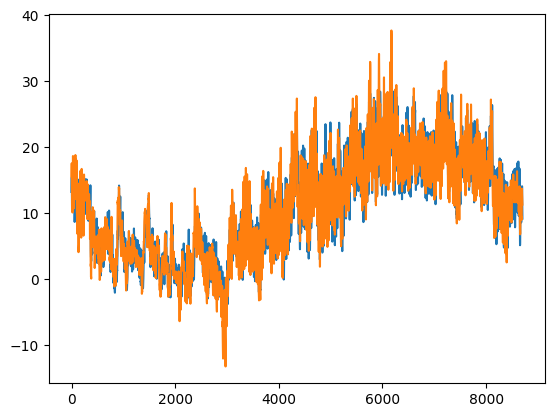

In [36]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
ax.plot(y_pred[:,-1])
ax.plot(y_test_all[:,-1])

In [38]:
print(data.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test_all.shape)
print(y_test_all.shape)
print(y_pred.shape)

(43848, 14)
(24360, 336, 14)
(24360, 12)
(8701, 336, 14)
(8701, 12)
(8701, 12)


In [39]:
for i in range(5):  # Show first 5 predictions
    print(f"Prediction {i}: {y_pred[i]}")
    print(f"Actual {i}: {y_test_all[i]}")
    print("---")

# Calculate overall performance
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test_all, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_all, y_pred))

print(f"Overall MAE: {mae:.4f}")
print(f"Overall RMSE: {rmse:.4f}")

Prediction 0: [11.772455 11.415252 11.119771 10.986012 10.950813 11.09338  11.245527
 11.537544 11.938844 12.348024 12.746955 13.226793]
Actual 0: [11.85850048 11.55850029 10.55850029  9.80850029  9.5085001   9.40850067
  9.2585001   9.30850029 10.95849991 13.05850029 14.70849991 15.55850029]
---
Prediction 1: [11.496595  11.195337  10.982     10.958007  11.066183  11.353399
 11.664771  12.1080265 12.619122  13.106648  13.552068  14.030101 ]
Actual 1: [11.55850029 10.55850029  9.80850029  9.5085001   9.40850067  9.2585001
  9.30850029 10.95849991 13.05850029 14.70849991 15.55850029 16.30850029]
---
Prediction 2: [10.999644  10.79223   10.692981  10.8058    11.0883875 11.537993
 12.024259  12.621768  13.244714  13.7997055 14.270993  14.7231655]
Actual 2: [10.55850029  9.80850029  9.5085001   9.40850067  9.2585001   9.30850029
 10.95849991 13.05850029 14.70849991 15.55850029 16.30850029 16.85849953]
---
Prediction 3: [ 9.978394  9.931515 10.015225 10.321999 10.822363 11.459383 12.127003


In [41]:
X_test_future = data[-336:].values.reshape(1, 336, 14)  # Shape: (1, 336, 14)

print(f"X_test_future shape: {X_test_future.shape}")

X_test_future shape: (1, 336, 14)


In [42]:
y_pred_future = model.predict(X_test_future)  # Shape: (1, 12)

print(f"Prediction for next 12 hours shape: {y_pred_future.shape}")
print(f"Predicted values: {y_pred_future[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction for next 12 hours shape: (1, 12)
Predicted values: [10.689438  10.323877  10.065942   9.946542   9.927813  10.074061
 10.243646  10.516515  10.915865  11.35912   11.7806225 12.279446 ]
